# OPERA RTC Validation: Cross Correlation-based Relative Geolocation of a Stack

**Eric Lundell & Franz J Meyer; Alaska Satellite Facility, University of Alaska Fairbanks**
 
** This notebook is best ran on a machine that can handle 120 GB RAM and 32 CPUs **

This notebook analyzes the relative geolocation quality of OPERA RTC products using cross-correlation of images in a stack. The notebook assumes that a stack of RTC scenes have been created and put into the `./work/original/` directory (possibly through the accompanying `1b_get_prepared_data_from_s3` notebook).

Once imports are imported, Dask is initialized (section 0), and VVs are selected (section 1), the rest of the notebook can be run automatically. Once a section is run, a sequential section can be reran independently. This can reduce the non-linear aspects of notebooks and also allow for more playing with code.   

The following procedures will be applied in this notebook:

1. Select VV tiffs from prepared stack. Any `*_vv.tif` within the selected directory or child directories will be copied. Move tiffs to `./.work/original/`.
1. Superset tiffs to a common AOI and save re-formatted tiffs in `./work/superset/`.
1. Due to spikes in data, flatten the tiffs by chopping off the bottom 1% and top 1%. Save tiffs in `./work/flatten/`.
1. Because of NaNs and other areas of no-data, evenly tile the tiffs (default to 8x8). To speed things up, we use a Dask LocalCluster to multiprocess. Tiles are saved in `./work/tiles/`.
1. Apply the cross-correlation function to the individual tile nearest-chronological pairs. If more than 10% of a tile is NaNs, treat the whole tile as a NaN. Any remaining NaNs are converted to zero. Data is upscaled by a factor of ten. The cross correlation results include the shift in x and y and the RMSE. Results are converted from degrees to meters. The results are saved as json files for each tile pair in `./work/correlation/`.
1. Perform analysis on json results. Results are read into a Pandas DataFrame. A statistical description and graph of the results are shown in two ways: all tiles in a scene are averaged and all tiles are averaged in time. 

<hr>

# 0. OPERA RTC Relative Geolocation Requirement

<div class="alert alert-success">
<i>The Sentinel-1-based RTC product (RTC-S1) shall meet a relative geolocation accuracy better than or equal to 6 meters given the 30 meter RTC-S1 product resolution (i.e. 20% of the product resolution), excluding the effects of DEM errors, for at least 80% of all validation products considered.</i>
</div>

<hr>

# 1. Load Necessary Libraries

In [24]:
import pathlib
import math
from datetime import datetime
import re
import json

from ipyfilechooser import FileChooser
import rasterio
from rasterio.mask import mask
from shapely import geometry
from osgeo import gdal
import pandas as pd
import numpy as np
import dask.distributed
from skimage.registration import phase_cross_correlation
import matplotlib.pyplot as plt

import opensarlab_lib as asfn

%matplotlib inline

# Get working directory of notebook
CWD = pathlib.Path().cwd()
CWD

METERS_PER_PIXEL = 30

<hr>

# 2. Setup Dask Methods

Dask on a LocalCluster is used for multiprocessing to make some operations go faster. It is assumed that only one Dask client is used at one time.

In [25]:
def setup_dask(ram_per_worker_gb:int=20, num_workers:int=20, num_threads_per_worker:int=1) -> dask.distributed.Client:
    cluster = dask.distributed.LocalCluster(
        threads_per_worker=num_threads_per_worker,
        n_workers=num_workers,
        memory_limit=f"{ram_per_worker_gb}GB",
        processes=True
    )

    return dask.distributed.Client(cluster)

def teardown_dask(client: dask.distributed.Client) -> None:
    client.shutdown()

def do_dask(client: dask.distributed.Client, callback, args: list):
    try:
        futures = client.map(callback, args)
        dask.distributed.progress(futures)
    except Exception as e:
        print(f"Error in dask: {e}")
        teardown_dask(client)
        return
    
    _  = client.gather(futures)

<hr>

# 3. Select OPERA VV-Polarized RTC Image Stack

Choose the parent directory of all child directories that contain the desired stack of VVs

In [3]:
fc = FileChooser(f'{CWD}/')
fc.show_only_dirs = True
display(fc)

FileChooser(path='/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation', filename='', tit…

In [4]:
# Remove any staged intermediate files to work in a clean area
!mkdir -p "{CWD}/work/original"
for filepath in pathlib.Path(f"{CWD}/work/original").glob("*.tif*"):
    filepath.unlink()

In [5]:
all_vv_paths = pathlib.Path(fc.selected_path).glob("**/*_VV.tif*")

# Move desired products to work directory.
for source_path in all_vv_paths:
    print(f"Copying {source_path} to {CWD}/work/original/{source_path.name}")
    !cp "{source_path}" "{CWD}/work/original/{source_path.name}"

Copying /home/jovyan/notebooks/SAR_Training/English/HydroSAR/ProcessOwnData/2022-Honduras/FullFrames/20200902T235811_VV.tif to /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20200902T235811_VV.tif
Copying /home/jovyan/notebooks/SAR_Training/English/HydroSAR/ProcessOwnData/2022-Honduras/FullFrames/20201020T235812_VV.tif to /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20201020T235812_VV.tif
Copying /home/jovyan/notebooks/SAR_Training/English/HydroSAR/ProcessOwnData/2022-Honduras/FullFrames/20210112T235809_VV.tif to /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20210112T235809_VV.tif
Copying /home/jovyan/notebooks/SAR_Training/English/HydroSAR/ProcessOwnData/2022-Honduras/FullFrames/20210124T235809_VV.tif to /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20210124T235809_VV.tif
Copying /home/jovyan/notebooks/SAR_Training/Engl

<hr>

# 4. Superset OPERA VV-Polarized RTC Images

Scene frames have a tendency to move over time. This means that the extant coverage for the whole scene is always different per frame. For the cross-correlation to properly work and for more accurate comparison, all the scenes need to be "normalized" by increasing/decreasing the size of the square extant. 

From extant metadata, get the full superset coordinates for all stack scenes.

In [6]:
# Open all the tiffs and get overall coords.
superset = {
    'left': math.inf,
    'bottom': math.inf,
    'right': -math.inf,
    'top': -math.inf
}

# The SRS is set to the first raster. It is assumed that the SRSs are the same (or close enough) for all.
output_srs = None

vv_original_paths = pathlib.Path(f"{CWD}/work/original").glob(f"*_VV.tif*")

for i, original_path in enumerate(vv_original_paths):

    raster = rasterio.open(original_path)    
    raster_bounds = raster.bounds
    print(raster_bounds)
    
    if i == 0:
        output_srs = raster.crs
    
    superset = {
        'left': min(superset['left'], raster_bounds.left),
        'bottom': min(superset['bottom'], raster_bounds.bottom), 
        'right': max(superset['right'], raster_bounds.right), 
        'top': max(superset['top'], raster_bounds.top)
    }

print(f"Superset box coords: {superset}")
print(f"Output SRS: {output_srs}")

BoundingBox(left=368970.0, bottom=1580670.0, right=657390.0, top=1810770.0)
BoundingBox(left=368820.0, bottom=1580700.0, right=657270.0, top=1810770.0)
BoundingBox(left=368850.0, bottom=1580640.0, right=657300.0, top=1810740.0)
BoundingBox(left=368880.0, bottom=1580610.0, right=657330.0, top=1810800.0)
BoundingBox(left=368850.0, bottom=1580640.0, right=657270.0, top=1810740.0)
BoundingBox(left=368850.0, bottom=1580700.0, right=657270.0, top=1810890.0)
BoundingBox(left=368790.0, bottom=1580670.0, right=657240.0, top=1810800.0)
BoundingBox(left=368760.0, bottom=1580700.0, right=657210.0, top=1810800.0)
BoundingBox(left=368700.0, bottom=1580700.0, right=657150.0, top=1810830.0)
BoundingBox(left=368850.0, bottom=1580640.0, right=657300.0, top=1810770.0)
BoundingBox(left=368790.0, bottom=1580700.0, right=657210.0, top=1810800.0)
BoundingBox(left=368790.0, bottom=1580670.0, right=657240.0, top=1810830.0)
BoundingBox(left=368880.0, bottom=1580670.0, right=657330.0, top=1810800.0)
BoundingBox(

In [7]:
# Remove any staged intermediate files to work in a clean area
!mkdir -p "{CWD}/work/superset"
for filepath in pathlib.Path(f"{CWD}/work/superset").glob("*.tif*"):
    filepath.unlink()

In [8]:
output_bounds = (
            superset['left'], 
            superset['bottom'],
            superset['right'],
            superset['top'],
        )

print(f"Output bounds (superset) set to '{output_bounds}'")
print(f"Output SRS set to '{output_srs}'")

# Superset and save VVs
vv_original_paths = pathlib.Path(f"{CWD}/work/original").glob(f"*_VV.tif*")
for original_path in vv_original_paths:
    
    superset_path = pathlib.Path(str(original_path).replace('original', 'superset'))
    print(f"Taking {original_path} and supersetting to {superset_path}")
    
    gdal.Warp(
        str(superset_path),
        str(original_path), 
        outputBounds=output_bounds,
        outputBoundsSRS=output_srs
    )
    

Output bounds (superset) set to '(359220.0, 1580610.0, 657390.0, 1859940.0)'
Output SRS set to 'EPSG:32616'
Taking /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20200902T235811_VV.tif and supersetting to /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20200902T235811_VV.tif
Taking /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20201020T235812_VV.tif and supersetting to /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20201020T235812_VV.tif
Taking /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20210112T235809_VV.tif and supersetting to /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20210112T235809_VV.tif
Taking /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20210124T235809_VV.tif and supersetting to /home/j

ERROR 1: TIFFFillTile:Read error at row 2048, col 3072, tile 912; got 0 bytes, expected 276
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20201231T235810_VV.tif, band 1: IReadBlock failed at X offset 0, Y offset 24: TIFFReadEncodedTile() failed.


Taking /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20201219T235810_VV.tif and supersetting to /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20201219T235810_VV.tif
Taking /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20201008T235812_VV.tif and supersetting to /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20201008T235812_VV.tif
Taking /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20201101T235812_VV.tif and supersetting to /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20201101T235812_VV.tif
Taking /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/original/20201207T235811_VV.tif and supersetting to /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20201207T235811_VV.tif
Taki

<hr>

# 5. Flatten and Save VVs

Often the VVs have extraneous high and low values that make matching difficult. So we need to get rid of these and save the intermediate results.

In [9]:
# Remove any staged intermediate files to work in a clean area
!mkdir -p "{CWD}/work/flatten"
for filepath in pathlib.Path(f"{CWD}/work/flatten").glob("*.tif*"):
    filepath.unlink()

In [10]:
def flatten(df: pd.DataFrame) -> pd.DataFrame:
    """
    Truncated values become NaNs
    """
    df[df < np.nanpercentile(df, 1)] = np.nan
    df[df > np.nanpercentile(df, 99)] = np.nan
    return df

# Flatten and save VVs
superset_vv_paths = pathlib.Path(f"{CWD}/work/superset").glob(f"*_VV.tif*")

for superset_path in superset_vv_paths:
    print(f"Flattening {superset_path}")
    
    # Convert raster to dataframe
    raster = rasterio.open(superset_path)
    raster_metadata = raster.meta

    raster0 = raster.read(1)
    df_superset = pd.DataFrame(raster0)
    
    # Flatten raster data
    df_flatten = flatten(df_superset)
    
    flatten_path = pathlib.Path(str(superset_path).replace('superset', 'flatten'))
    
    with rasterio.open(flatten_path, 'w', **raster_metadata) as out:
        out.write(df_flatten, 1)

Flattening /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20200902T235811_VV.tif
Flattening /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20201020T235812_VV.tif
Flattening /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20210112T235809_VV.tif
Flattening /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20210124T235809_VV.tif
Flattening /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20201113T235812_VV.tif
Flattening /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20200914T235811_VV.tif
Flattening /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20201231T235810_VV.tif
Flattening /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/superset/20201219T235810_VV.tif
Flattening /home/jovyan/

<hr>

# 6. Tile and Save VVs

In [11]:
def split_into_cells_args(x_num: int, y_num: int) -> list:
    """
    return list of dict of args for `split_into_cells` dask function callback.
    """
    
    args = []
    for i, flatten_path in enumerate(flatten_vv_paths):
        args.append({
            'input_number': i, 
            'input_file': flatten_path, 
            'output_dir': f"{CWD}/work/tiles", 
            'x_num': x_num, 
            'y_num': y_num
        })
    
    return args 

# https://gis.stackexchange.com/a/306862
# Takes a Rasterio dataset and splits it into squares of dimensions squareDim * squareDim
def split_into_cells(args):
    """
    input_number: A sequential number representing the ordering of the scenes. This is to make later scene pairing easier.
    input_file: Full file path of scene to be tiled.
    output_dir: Full path of directory to place tiles.
    x_num: Number of tiles formed in the x direction per scene.
    y_num: Number of tiles formed in the y direction per scene.
    """
    
    input_number: int = args['input_number']
    input_file: str = args['input_file']
    output_dir: str = args['output_dir']
    x_num: int = args.get('x_num', 1)
    y_num: int = args.get('y_num', 1)
    
    print(f"Tileing {input_file}")

    
    raster = rasterio.open(input_file)
    
    x_dim = raster.shape[1] // x_num
    y_dim = raster.shape[0] // y_num

    x, y = 0, 0
    for y_iter in range(y_num):
        y = y_iter * y_dim
        for x_iter in range(x_num):
            x = x_iter * x_dim
            
            input_filestem = pathlib.Path(input_file).stem
            
            output_file = f'{input_filestem}_{input_number}_{y_iter}_{x_iter}.tif*'
            print(f"Creating tile {output_file}...")
            
            # Get tile geometry
            corner1 = raster.transform * (x, y)
            corner2 = raster.transform * (x + x_dim, y + y_dim)
            geom = geometry.box(corner1[0], corner1[1], corner2[0], corner2[1])
            
            # Get cell 
            crop, cropTransform = mask(raster, [geom], crop=True)
            raster.meta.update(
                {
                    "driver": "GTiff",
                    "height": crop.shape[1],
                    "width": crop.shape[2],
                    "transform": cropTransform,
                    "crs": raster.crs
                }
            )
                        
            output_filepath = f"{output_dir}/{output_file}"
            with rasterio.open(output_filepath, "w", **raster.meta) as out:
                out.write(crop)

In [12]:
# Remove any staged intermediate files to work in a clean area
!mkdir -p "{CWD}/work/tiles"
for filepath in pathlib.Path(f"{CWD}/work/tiles").glob("*.tif*"):
    filepath.unlink()

In [13]:
X_NUM = 8
Y_NUM = 8

flatten_vv_paths = pathlib.Path(f"{CWD}/work/flatten").glob(f"*_VV.tif*")
start_time = datetime.now()
print(f"\nStart time is {start_time}")

client = setup_dask(ram_per_worker_gb=20, num_workers=100, num_threads_per_worker=1)
do_dask(client, split_into_cells, split_into_cells_args(x_num=X_NUM, y_num=Y_NUM))

teardown_dask(client)

end_time = datetime.now()
print(f"\nEnd time is {end_time}")
print(f"Time elapsed is {end_time - start_time}\n")  


Start time is 2023-05-03 06:25:05.190903
Tileing /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/flatten/20210112T235809_VV.tif
Creating tile 20210112T235809_VV_2_0_0.tif*...
Creating tile 20210112T235809_VV_2_0_1.tif*...
Creating tile 20210112T235809_VV_2_0_2.tif*...
Creating tile 20210112T235809_VV_2_0_3.tif*...
Creating tile 20210112T235809_VV_2_0_4.tif*...
Creating tile 20210112T235809_VV_2_0_5.tif*...
Creating tile 20210112T235809_VV_2_0_6.tif*...
Creating tile 20210112T235809_VV_2_0_7.tif*...
Creating tile 20210112T235809_VV_2_1_0.tif*...
Creating tile 20210112T235809_VV_2_1_1.tif*...
Creating tile 20210112T235809_VV_2_1_2.tif*...
Creating tile 20210112T235809_VV_2_1_3.tif*...
Creating tile 20210112T235809_VV_2_1_4.tif*...
Creating tile 20210112T235809_VV_2_1_5.tif*...
Creating tile 20210112T235809_VV_2_1_6.tif*...
Creating tile 20210112T235809_VV_2_1_7.tif*...
Creating tile 20210112T235809_VV_2_2_0.tif*...
Creating tile 20210112T235809_VV_2_2_1.ti

2023-05-03 06:38:25,445 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/worker.py", line 1237, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.

Tileing /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/flatten/20201008T235812_VV.tif
Creating tile 20201008T235812_VV_8_0_0.tif*...
Creating tile 20201008T235812_VV_8_0_1.tif*...
Creating tile 20201008T235812_VV_8_0_2.tif*...
Creating tile 20201008T235812_VV_8_0_3.tif*...
Creating tile 20201008T235812_VV_8_0_4.tif*...
Creating tile 20201008T235812_VV_8_0_5.tif*...
Creating tile 20201008T235812_VV_8_0_6.tif*...
Creating tile 20201008T235812_VV_8_0_7.tif*...
Creating tile 20201008T235812_VV_8_1_0.tif*...
Creating tile 20201008T235812_VV_8_1_1.tif*...
Creating tile 20201008T235812_VV_8_1_2.tif*...
Creating tile 20201008T235812_VV_8_1_3.tif*...
Creating tile 20201008T235812_VV_8_1_4.tif*...
Creating tile 20201008T235812_VV_8_1_5.tif*...
Creating tile 20201008T235812_VV_8_1_6.tif*...
Creating tile 20201008T235812_VV_8_1_7.tif*...
Creating tile 20201008T235812_VV_8_2_0.tif*...
Creating tile 20201008T235812_VV_8_2_1.tif*...
Creating tile 20201008T235812_VV_8_2

2023-05-03 06:38:25,842 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/worker.py", line 1237, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.

0200914T235811_VV_5_7_5.tif*...
Creating tile 20200914T235811_VV_5_7_6.tif*...
Creating tile 20200914T235811_VV_5_7_7.tif*...


2023-05-03 06:38:26,131 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/worker.py", line 1237, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.

Tileing /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/flatten/20201101T235812_VV.tif
Creating tile 20201101T235812_VV_9_0_0.tif*...
Creating tile 20201101T235812_VV_9_0_1.tif*...
Creating tile 20201101T235812_VV_9_0_2.tif*...
Creating tile 20201101T235812_VV_9_0_3.tif*...
Creating tile 20201101T235812_VV_9_0_4.tif*...
Creating tile 20201101T235812_VV_9_0_5.tif*...
Creating tile 20201101T235812_VV_9_0_6.tif*...
Creating tile 20201101T235812_VV_9_0_7.tif*...
Creating tile 20201101T235812_VV_9_1_0.tif*...
Creating tile 20201101T235812_VV_9_1_1.tif*...
Creating tile 20201101T235812_VV_9_1_2.tif*...
Creating tile 20201101T235812_VV_9_1_3.tif*...
Creating tile 20201101T235812_VV_9_1_4.tif*...
Creating tile 20201101T235812_VV_9_1_5.tif*...
Creating tile 20201101T235812_VV_9_1_6.tif*...
Creating tile 20201101T235812_VV_9_1_7.tif*...
Creating tile 20201101T235812_VV_9_2_0.tif*...
Creating tile 20201101T235812_VV_9_2_1.tif*...
Creating tile 20201101T235812_VV_9_2

2023-05-03 06:38:26,344 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/worker.py", line 1237, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.

Tileing /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/flatten/20200902T235811_VV.tif
Creating tile 20200902T235811_VV_0_0_0.tif*...
Creating tile 20200902T235811_VV_0_0_1.tif*...
Creating tile 20200902T235811_VV_0_0_2.tif*...
Creating tile 20200902T235811_VV_0_0_3.tif*...
Creating tile 20200902T235811_VV_0_0_4.tif*...
Creating tile 20200902T235811_VV_0_0_5.tif*...
Creating tile 20200902T235811_VV_0_0_6.tif*...
Creating tile 20200902T235811_VV_0_0_7.tif*...
Creating tile 20200902T235811_VV_0_1_0.tif*...
Creating tile 20200902T235811_VV_0_1_1.tif*...
Creating tile 20200902T235811_VV_0_1_2.tif*...
Creating tile 20200902T235811_VV_0_1_3.tif*...
Creating tile 20200902T235811_VV_0_1_4.tif*...
Creating tile 20200902T235811_VV_0_1_5.tif*...
Creating tile 20200902T235811_VV_0_1_6.tif*...
Creating tile 20200902T235811_VV_0_1_7.tif*...
Creating tile 20200902T235811_VV_0_2_0.tif*...
Creating tile 20200902T235811_VV_0_2_1.tif*...
Creating tile 20200902T235811_VV_0_2

2023-05-03 06:38:27,545 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/worker.py", line 1237, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.

Tileing /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/flatten/20201020T235812_VV.tif
Creating tile 20201020T235812_VV_1_0_0.tif*...
Creating tile 20201020T235812_VV_1_0_1.tif*...
Creating tile 20201020T235812_VV_1_0_2.tif*...
Creating tile 20201020T235812_VV_1_0_3.tif*...
Creating tile 20201020T235812_VV_1_0_4.tif*...
Creating tile 20201020T235812_VV_1_0_5.tif*...
Creating tile 20201020T235812_VV_1_0_6.tif*...
Creating tile 20201020T235812_VV_1_0_7.tif*...
Creating tile 20201020T235812_VV_1_1_0.tif*...
Creating tile 20201020T235812_VV_1_1_1.tif*...
Creating tile 20201020T235812_VV_1_1_2.tif*...
Creating tile 20201020T235812_VV_1_1_3.tif*...
Creating tile 20201020T235812_VV_1_1_4.tif*...
Creating tile 20201020T235812_VV_1_1_5.tif*...
Creating tile 20201020T235812_VV_1_1_6.tif*...
Creating tile 20201020T235812_VV_1_1_7.tif*...
Creating tile 20201020T235812_VV_1_2_0.tif*...
Creating tile 20201020T235812_VV_1_2_1.tif*...
Creating tile 20201020T235812_VV_1_2

2023-05-03 06:38:28,347 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/worker.py", line 1237, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.

Tileing /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/flatten/20201026T235735_VV.tif
Creating tile 20201026T235735_VV_13_0_0.tif*...
Creating tile 20201026T235735_VV_13_0_1.tif*...
Creating tile 20201026T235735_VV_13_0_2.tif*...
Creating tile 20201026T235735_VV_13_0_3.tif*...
Creating tile 20201026T235735_VV_13_0_4.tif*...
Creating tile 20201026T235735_VV_13_0_5.tif*...
Creating tile 20201026T235735_VV_13_0_6.tif*...
Creating tile 20201026T235735_VV_13_0_7.tif*...
Creating tile 20201026T235735_VV_13_1_0.tif*...
Creating tile 20201026T235735_VV_13_1_1.tif*...
Creating tile 20201026T235735_VV_13_1_2.tif*...
Creating tile 20201026T235735_VV_13_1_3.tif*...
Creating tile 20201026T235735_VV_13_1_4.tif*...
Creating tile 20201026T235735_VV_13_1_5.tif*...
Creating tile 20201026T235735_VV_13_1_6.tif*...
Creating tile 20201026T235735_VV_13_1_7.tif*...
Creating tile 20201026T235735_VV_13_2_0.tif*...
Creating tile 20201026T235735_VV_13_2_1.tif*...
Creating tile 2020

2023-05-03 06:38:29,740 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/worker.py", line 1237, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.

Tileing /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/flatten/20210124T235809_VV.tif
Creating tile 20210124T235809_VV_3_0_0.tif*...
Creating tile 20210124T235809_VV_3_0_1.tif*...
Creating tile 20210124T235809_VV_3_0_2.tif*...
Creating tile 20210124T235809_VV_3_0_3.tif*...
Creating tile 20210124T235809_VV_3_0_4.tif*...
Creating tile 20210124T235809_VV_3_0_5.tif*...
Creating tile 20210124T235809_VV_3_0_6.tif*...
Creating tile 20210124T235809_VV_3_0_7.tif*...
Creating tile 20210124T235809_VV_3_1_0.tif*...
Creating tile 20210124T235809_VV_3_1_1.tif*...
Creating tile 20210124T235809_VV_3_1_2.tif*...
Creating tile 20210124T235809_VV_3_1_3.tif*...
Creating tile 20210124T235809_VV_3_1_4.tif*...
Creating tile 20210124T235809_VV_3_1_5.tif*...
Creating tile 20210124T235809_VV_3_1_6.tif*...
Creating tile 20210124T235809_VV_3_1_7.tif*...
Creating tile 20210124T235809_VV_3_2_0.tif*...
Creating tile 20210124T235809_VV_3_2_1.tif*...
Creating tile 20210124T235809_VV_3_2

2023-05-03 06:38:29,951 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/worker.py", line 1237, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.

Tileing /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/flatten/20200926T235812_VV.tif
Creating tile 20200926T235812_VV_11_0_0.tif*...
Creating tile 20200926T235812_VV_11_0_1.tif*...
Creating tile 20200926T235812_VV_11_0_2.tif*...
Creating tile 20200926T235812_VV_11_0_3.tif*...
Creating tile 20200926T235812_VV_11_0_4.tif*...
Creating tile 20200926T235812_VV_11_0_5.tif*...
Creating tile 20200926T235812_VV_11_0_6.tif*...
Creating tile 20200926T235812_VV_11_0_7.tif*...
Creating tile 20200926T235812_VV_11_1_0.tif*...
Creating tile 20200926T235812_VV_11_1_1.tif*...
Creating tile 20200926T235812_VV_11_1_2.tif*...
Creating tile 20200926T235812_VV_11_1_3.tif*...
Creating tile 20200926T235812_VV_11_1_4.tif*...
Creating tile 20200926T235812_VV_11_1_5.tif*...
Creating tile 20200926T235812_VV_11_1_6.tif*...
Creating tile 20200926T235812_VV_11_1_7.tif*...
Creating tile 20200926T235812_VV_11_2_0.tif*...
Creating tile 20200926T235812_VV_11_2_1.tif*...
Creating tile 2020

2023-05-03 06:38:30,244 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/worker.py", line 1237, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.

Tileing /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/flatten/20201219T235810_VV.tif
Creating tile 20201219T235810_VV_7_0_0.tif*...
Creating tile 20201219T235810_VV_7_0_1.tif*...
Creating tile 20201219T235810_VV_7_0_2.tif*...
Creating tile 20201219T235810_VV_7_0_3.tif*...
Creating tile 20201219T235810_VV_7_0_4.tif*...
Creating tile 20201219T235810_VV_7_0_5.tif*...
Creating tile 20201219T235810_VV_7_0_6.tif*...
Creating tile 20201219T235810_VV_7_0_7.tif*...
Creating tile 20201219T235810_VV_7_1_0.tif*...
Creating tile 20201219T235810_VV_7_1_1.tif*...
Creating tile 20201219T235810_VV_7_1_2.tif*...
Creating tile 20201219T235810_VV_7_1_3.tif*...
Creating tile 20201219T235810_VV_7_1_4.tif*...
Creating tile 20201219T235810_VV_7_1_5.tif*...
Creating tile 20201219T235810_VV_7_1_6.tif*...
Creating tile 20201219T235810_VV_7_1_7.tif*...
Creating tile 20201219T235810_VV_7_2_0.tif*...
Creating tile 20201219T235810_VV_7_2_1.tif*...
Creating tile 20201219T235810_VV_7_2

2023-05-03 06:38:30,548 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/worker.py", line 1237, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.

Tileing /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/flatten/20201231T235810_VV.tif
Creating tile 20201231T235810_VV_6_0_0.tif*...
Creating tile 20201231T235810_VV_6_0_1.tif*...
Creating tile 20201231T235810_VV_6_0_2.tif*...
Creating tile 20201231T235810_VV_6_0_3.tif*...
Creating tile 20201231T235810_VV_6_0_4.tif*...
Creating tile 20201231T235810_VV_6_0_5.tif*...
Creating tile 20201231T235810_VV_6_0_6.tif*...
Creating tile 20201231T235810_VV_6_0_7.tif*...
Creating tile 20201231T235810_VV_6_1_0.tif*...
Creating tile 20201231T235810_VV_6_1_1.tif*...
Creating tile 20201231T235810_VV_6_1_2.tif*...
Creating tile 20201231T235810_VV_6_1_3.tif*...
Creating tile 20201231T235810_VV_6_1_4.tif*...
Creating tile 20201231T235810_VV_6_1_5.tif*...
Creating tile 20201231T235810_VV_6_1_6.tif*...
Creating tile 20201231T235810_VV_6_1_7.tif*...
Creating tile 20201231T235810_VV_6_2_0.tif*...
Creating tile 20201231T235810_VV_6_2_1.tif*...
Creating tile 20201231T235810_VV_6_2

<hr>

# 7. Correlate Tiles and Save Results

In [14]:
def get_correlation_args() -> list:
    """
    return [
        {
            'reference_index': '',
            'secondary_index': '',
            'tile_number_x': '',
            'tile_number_y': '',
            'ref_file_path': '',
            'sec_file_path': ''
        },
    ]
    """
    
    tiles_paths = pathlib.Path(f"{CWD}/work/tiles").glob(f"*.tif*")
    tiles = []
    
    # Get index and tile numbers from path
    for tiles_path in tiles_paths:

        m = re.match(r".*_([0-9]+)_([0-9]+)_([0-9]+).tif*", tiles_path.name)

        tiles.append({
            'index': m.group(1),
            'tile_number_x': m.group(2),
            'tile_number_y': m.group(3),
            'file_path': tiles_path
        })

    tiles_df = pd.DataFrame(tiles).sort_values(by=['tile_number_x', 'tile_number_y', 'index'])

    paris = []
    for i in range(len(tiles_df.index) - 1):

        #if i > 10:
        #    continue
        
        ref_row = tiles_df.iloc[i]
        sec_row = tiles_df.iloc[i+1]

        # If the next row in the sorted dataframe has different tile numbers, then we are at a new set
        if ref_row['tile_number_x'] != sec_row['tile_number_x'] or ref_row['tile_number_y'] != sec_row['tile_number_y']:
            continue

        paris.append({
            'reference_index': ref_row['index'],
            'secondary_index': sec_row['index'],
            'tile_number_x': ref_row['tile_number_x'],
            'tile_number_y': ref_row['tile_number_y'],
            'ref_file_path': ref_row['file_path'],
            'sec_file_path': sec_row['file_path']
        })

    return paris

def correlation_callback(args: dict) -> dict:
    """
    args = {
        'reference_index': '',
        'secondary_index': '',
        'tile_number_x': '',
        'tile_number_y': '',
        'ref_file_path': '',
        'sec_file_path': ''
    }
    """
    
    try:
        reference_index = args['reference_index']
        secondary_index = args['secondary_index']
        tile_number_x = args['tile_number_x']
        tile_number_y = args['tile_number_y']
        ref_file_path = args['ref_file_path']
        sec_file_path = args['sec_file_path']
        
        ###### Reference 
        stime = datetime.now()
        print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Rendering {ref_file_path}...")
        rast = rasterio.open(ref_file_path)
        raster0 = rast.read(1)
        df_ref = pd.DataFrame(raster0)
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Time to complete ref: {datetime.now() - stime}")


        ###### Secondary
        stime = datetime.now()
        print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Rendering {sec_file_path}...")
        rast = rasterio.open(sec_file_path)
        raster0 = rast.read(1)
        df_sec = pd.DataFrame(raster0)
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Time to complete sec: {datetime.now() - stime}")


        ###### If crop tile is more than 10% NANs, skip correlation and set return values to NaN 
        def get_percent_nans(df):
            number_of_elements = df.size
            number_of_nans = df.isnull().sum().sum()

            return number_of_nans / number_of_elements

        percent_nans_ref = get_percent_nans(df_ref)
        percent_nans_sec = get_percent_nans(df_sec)

        if percent_nans_ref > 0.10 or percent_nans_sec > 0.10:
            print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Too many NaNs. Skipping correlation....")

            result = {
                "reference_index": int(reference_index),
                "secondary_index": int(secondary_index),
                "tile_number_x": int(tile_number_x),
                "tile_number_y": int(tile_number_y),
                "ref_file": str(ref_file_path),
                "sec_file": str(sec_file_path),
                "shift_x": np.nan,
                "shift_y": np.nan, 
                "error": np.nan, 
                "phase": np.nan,
                "message": "Too many NaNs"
            }

        ####### Cross corr without masking
        stime = datetime.now()
        print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Finding phase correlation with nans set to zero....")
        shift, error, phase = phase_cross_correlation(
            df_ref.replace(np.nan, 0), 
            df_sec.replace(np.nan, 0),
            normalization=None,
            upsample_factor=10
        )
        
        shift = shift * METERS_PER_PIXEL
        error = error * METERS_PER_PIXEL
        
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Shift vector (in meters) required to register moving_image with reference_image: {shift}")
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Translation invariant normalized RMS error between reference_image and moving_image: {error}")
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Global phase difference between the two images (should be zero if images are non-negative).: {phase}\n")

        if len(list(shift)) != 2:
            result = {
                "reference_index": int(reference_index),
                "secondary_index": int(secondary_index),
                "tile_number_x": int(tile_number_x),
                "tile_number_y": int(tile_number_y),
                "ref_file": str(ref_file_path),
                "sec_file": str(sec_file_path),
                "shift_x": np.float64(shift[0]),
                "shift_y": np.float64(shift[1]),
                "error": np.nan, 
                "phase": np.nan,
                "message": "Shift is not a two element array"
            }
        
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}:  Time to complete correlation: {datetime.now() - stime}")


        ####### Write metadata to correlation result files

        result = {
            "reference_index": int(reference_index),
            "secondary_index": int(secondary_index),
            "tile_number_x": int(tile_number_x),
            "tile_number_y": int(tile_number_y),
            "ref_file": str(ref_file_path),
            "sec_file": str(sec_file_path),
            "shift_x": np.float64(shift[0]),
            "shift_y": np.float64(shift[1]),
            "error": np.float64(error), 
            "phase": np.float64(phase),
            "message": "Correlation successful"
        }

    except Exception as e:
        print(f"An error occurred: {e}")
        result = {
            "reference_index": int(reference_index),
            "secondary_index": int(secondary_index),
            "tile_number_x": int(tile_number_x),
            "tile_number_y": int(tile_number_y),
            "ref_file": str(ref_file_path),
            "sec_file": str(sec_file_path),
            "shift_x": np.nan, 
            "shift_y": np.nan,
            "error": np.nan, 
            "phase": np.nan,
            "message": f"Error: {e}"
        }
        
    try:
        result_file = pathlib.Path(f"{CWD}/work/correlation/index_{reference_index}_{secondary_index}-tile_{tile_number_x}_{tile_number_y}.json")
        with open(result_file, 'w') as f:
            json.dump(result, f)
    except Exception as e:
        print(f"An error occurred: {e}")

In [15]:
# Remove any staged intermediate files to work in a clean area
!mkdir -p "{CWD}/work/correlation"
for filepath in pathlib.Path(f"{CWD}/work/correlation").glob("*.json"):
    filepath.unlink()

In [16]:
start_time = datetime.now()
print(f"\nStart time is {start_time}")

# ram_per_worker_gb:int=20, num_workers:int=20, num_threads_per_worker:int=1
client = setup_dask(ram_per_worker_gb=11, num_workers=10)
do_dask(client, correlation_callback, get_correlation_args())

teardown_dask(client)

end_time = datetime.now()
print(f"\nEnd time is {end_time}")
print(f"Time elapsed is {end_time - start_time}\n")  


Start time is 2023-05-03 06:38:34.375453


/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:111: RuntimeWarning: invalid value encountered in scalar divide
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\
/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:111: RuntimeWarning: invalid value encountered in scalar divide
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\
/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:111: RuntimeWarning: invalid value encountered in scalar divide
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\
/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:111: RuntimeWarning: invalid value encountered in scalar divide
  error = 1.0 - cross_correlatio


Index 2 3, Tile 0 0: Rendering /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/tiles/20210112T235809_VV_2_0_0.tif*...
Index 2 3, Tile 0 0: Time to complete ref: 0:00:00.858523

Index 2 3, Tile 0 0: Rendering /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/tiles/20210124T235809_VV_3_0_0.tif*...
Index 2 3, Tile 0 0: Time to complete sec: 0:00:00.549977

Index 2 3, Tile 0 0: Finding phase correlation with nans set to zero....
Index 2 3, Tile 0 0: Shift vector (in meters) required to register moving_image with reference_image: [-21. -21.]
Index 2 3, Tile 0 0: Translation invariant normalized RMS error between reference_image and moving_image: nan
Index 2 3, Tile 0 0: Global phase difference between the two images (should be zero if images are non-negative).: -0.0

Index 2 3, Tile 0 0:  Time to complete correlation: 0:00:48.750963

Index 11 12, Tile 0 1: Rendering /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_ev

<hr>

# 8. Estimate Average Offsets Per Tile and For the Full Scene

Read the correlation result files from the previous section into a Pandas DataFrame.

Then perform various statistical analyses.

In [56]:
# Put results into 3D Pandas dataset
correlation_paths = pathlib.Path(f"{CWD}/work/correlation").glob(f"*.json")

results = []

for corr_path in correlation_paths:
    with open(corr_path, 'r') as f:
        results.append(json.load(f))

results_df = pd.DataFrame(results)

In [57]:
display(results_df)

,reference_index,secondary_index,tile_number_x,tile_number_y,ref_file,sec_file,shift_x,shift_y,error,phase,message
0,2,3,5,3,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0.0,0.0,10.309316,2.040124e-09,Correlation successful
1,11,12,2,0,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,-246.0,-723.0,5.238174,1.003129e-09,Correlation successful
2,5,6,5,6,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0.0,0.0,9.560168,9.373885e-10,Correlation successful
3,4,5,3,7,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0.0,-3.0,7.805185,1.113285e-10,Correlation successful
4,7,8,1,7,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,-21.0,-21.0,NaN,-0.000000e+00,Correlation successful
...,...,...,...,...,...,...,...,...,...,...,...
827,8,9,1,2,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,-21.0,-21.0,NaN,-0.000000e+00,Correlation successful
828,5,6,1,6,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,-237.0,249.0,21.806524,-2.135753e-08,Correlation successful
829,7,8,4,0,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0.0,0.0,13.326118,1.562429e-09,Correlation successful
830,1,10,1,5,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,231.0,9.0,7.787945,-9.627347e-09,Correlation successful


Display the stats for the shift, error, and phase of the cross-correlation between two scenes in the stack.

The `reference_index` is the order number of the reference scene within the stack. The stack scenes are ordered from newest to oldest.
The `secondary_index` is the order number of the secondary scene within the stack.

The `mean` value is a simple mean of all tile values. Similarity for `std`, etc.

## A. Combine all tiles per scene pair correlation results

The cross-correlation results of all tiles in Scene 1 and Scene 2 are re-assembled together into one result and statistically analyzed. Repeat for all pairs. 

**First, remove invalid matches:**

In [83]:
dfff = results_df
dfff['error'] = dfff[dfff['error'] < 10.0]['error']
dfff['shift_x'] = dfff[np.abs(dfff['shift_x']) < 50.0]['shift_x']
dfff['shift_y'] = dfff[np.abs(dfff['shift_y']) < 50.0]['shift_y']
no_nans = dfff[~dfff.isnull().any(axis=1)]

**Now calculate average scene-wide offsets along with their errors:**

,tile_mean_x,tile_mean_y,error
reference_index,,,
0,0.260870,1.826087,8.602081
1,0.625000,-1.125000,8.667801
2,-0.142857,-1.142857,8.826122
3,-0.875000,-1.500000,8.670186
4,1.304348,-1.956522,8.949712
5,-0.642857,0.000000,8.601336
6,0.352941,-0.705882,8.378564
7,0.409091,-0.681818,8.692003
8,-0.545455,-1.363636,8.677249


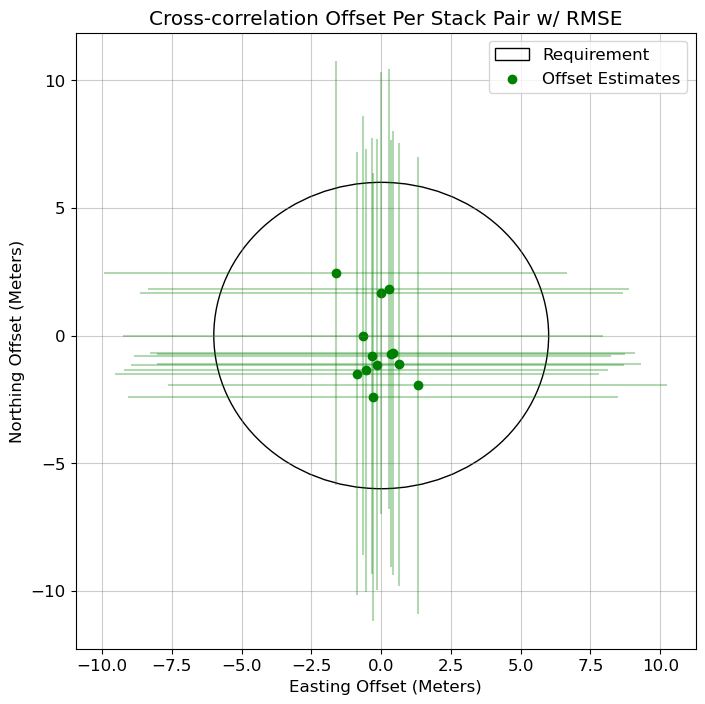

In [109]:
paired_dfff = no_nans.groupby(by=['reference_index'])

## Uncomment to display statistical descriptions of DataFrames
#display(paired_df['shift_x'].describe())
#display(paired_df['shift_y'].describe())
#display(paired_df['error'].describe())

display(paired_dfff)

# Take the Root Mean Square Error of the individual tile RMSE to get the overall RMSE.
def rms(series):
    if np.isnan(series).all():
        return np.nan  
    return np.sqrt(np.nanmean(np.square(series)))
    #return np.nanmean(np.abs(series))

pdfff = pd.DataFrame()
pdfff['tile_mean_x'] = paired_dfff['shift_x'].agg(['mean'])
pdfff['tile_mean_y'] = paired_dfff['shift_y'].agg(['mean'])
pdfff['error'] = paired_dfff['error'].agg(rms)
display(pdfff)

fig, ax = plt.subplots(figsize=(8,8))
Circle1= plt.Circle(( 0.0 , 0.0 ), 6.0, fill=False, label='Requirement')
ax.add_patch(Circle1)
plt.grid(color='grey', alpha=0.4)
plt.errorbar(pdfff['tile_mean_x'], pdfff['tile_mean_y'], yerr=pdfff['error'], xerr=pdfff['error'], ecolor='green', alpha=0.3, ls='none')
plt.scatter(pdfff['tile_mean_x'], pdfff['tile_mean_y'], color='green', label='Offset Estimates')
ax.legend()
plt.xlabel("Easting Offset (Meters)")
plt.ylabel("Northing Offset (Meters)")
plt.title("Cross-correlation Offset Per Stack Pair w/ RMSE")

plt.savefig('CrossCorrelationOffsets-FullFrame.png', dpi=300, transparent='true')

## B. Combine all tile correlation results temporally

The cross-correlation result of each individual tile for Scene 1 and Scene 2 are combined together temporally with the corresponding tile in later pairs. This creates a time series by tile. Repeat for all tiles. This is statistically analyzed. 

tile_mean_x  tile_mean_y     error
tile_number_x tile_number_y                                    
1             5                -2.000000    -4.000000  6.346025
              6               -12.000000     9.000000  6.395888
2             0                -4.500000     0.750000  8.240750
              1                 0.000000    -0.375000  6.375082
              2                 0.000000     0.000000  7.653916
              4                 3.000000     6.000000  7.113155
              6                 0.000000    -0.600000  8.896270
              7                -0.666667     3.333333  7.659620
3             1                 0.000000    -1.153846  7.704333
              2                 0.230769    -0.923077  8.719763
              3                 0.000000    -0.600000  9.742612
              5                 0.000000     0.000000  9.347350
              6                 0.000000    -0.230769  8.672071
              7                -0.230769     0.230769  8.279440
4             1                 0.000000     0.000000  9.590367
              4                 0.000000    -3.000000  9.633133
              7                 0.000000     0.000000  9.885617
5             0                 0.230769     0.692308  8.426065
              1                -0.230769    -0.923077  8.637157
              2                 0.000000    -2.000000  9.552081
              3                 0.000000    -3.000000  9.870009
              4                 0.333333    -2.333333  9.544488
              5                 0.000000    -2.000000  9.544192
              6                 0.000000    -1.000000  9.529170
6             0                 1.000000    -3.000000  9.188850
              1                 0.000000     0.000000  9.402196
              2                 0.000000    -2.000000  9.102329
              3                 0.000000    -2.000000  8.921961
              4                 0.428571    -2.142857  9.655701
              5                 0.000000    -1.000000  8.942049
              6                 0.000000    -0.333333  9.153445
              7                 0.000000     0.333333  8.006082
7             1                 0.000000    -1.500000  9.702340
              3                 1.000000    -1.333333  8.354065
              4                 1.000000    -0.666667  8.528091
              5                 0.333333    -0.666667  7.717764

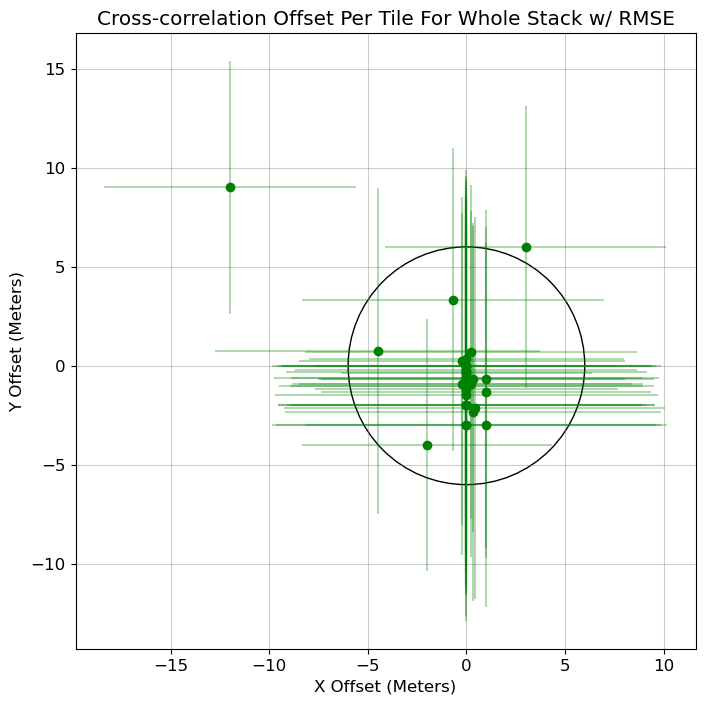

In [110]:
# temporal_df = results_df.groupby(by=['tile_number_x', 'tile_number_y'])
temporal_df = no_nans.groupby(by=['tile_number_x', 'tile_number_y'])


## Uncomment to display statistical descriptions of DataFrames
#display(temporal_df['shift_x'].describe())
#display(temporal_df['shift_y'].describe())
#display(temporal_df['error'].describe())

def rms(series):
    if np.isnan(series).all():
        return np.nan  
    return np.sqrt(np.nanmean(np.square(series)))
    #return np.nanmean(np.abs(series))

tdf = pd.DataFrame()
tdf['tile_mean_x'] = temporal_df['shift_x'].agg(['mean'])
tdf['tile_mean_y'] = temporal_df['shift_y'].agg(['mean'])
tdf['error'] = temporal_df['error'].agg(rms)
display(tdf)

fig, ax = plt.subplots(figsize=(8,8))
Circle1= plt.Circle(( 0.0 , 0.0 ), 6.0, fill=False)
ax.add_patch(Circle1)
plt.grid(color='grey', alpha=0.4)
plt.errorbar(tdf['tile_mean_x'], tdf['tile_mean_y'], yerr=tdf['error'], xerr=tdf['error'], ecolor='green', alpha=0.3, ls='none')
plt.scatter(tdf['tile_mean_x'], tdf['tile_mean_y'], color='green')
plt.xlabel("X Offset (Meters)")
plt.ylabel("Y Offset (Meters)")
plt.title("Cross-correlation Offset Per Tile For Whole Stack w/ RMSE")
plt.savefig('CrossCorrelationOffsets-Tiles.png', dpi=300, transparent='true')